
# Using Polar and Log-Polar Transformations for Registration

Phase correlation (``registration.phase_cross_correlation``) is an efficient
method for determining translation offset between pairs of similar images.
However this approach relies on a near absence of rotation/scaling differences
between the images, which are typical in real-world examples.

To recover rotation and scaling differences between two images, we can take
advantage of two geometric properties of the log-polar transform and the
translation invariance of the frequency domain. First, rotation in Cartesian
space becomes translation along the angular coordinate ($\theta$) axis
of log-polar space. Second, scaling in Cartesian space becomes translation
along the radial coordinate ($\rho = \ln\sqrt{x^2 + y^2}$) of log-polar
space. Finally, differences in translation in the spatial domain do not impact
magnitude spectrum in the frequency domain.

In this series of examples, we build on these concepts to show how the
log-polar transform ``transform.warp_polar`` can be used in conjunction with
phase correlation to recover rotation and scaling differences between two
images that also have a translation offset.


## Recover rotation difference with a polar transform

In this first example, we consider the simple case of two images that only
differ with respect to rotation around a common center point. By remapping
these images into polar space, the rotation difference becomes a simple
translation difference that can be recovered by phase correlation.



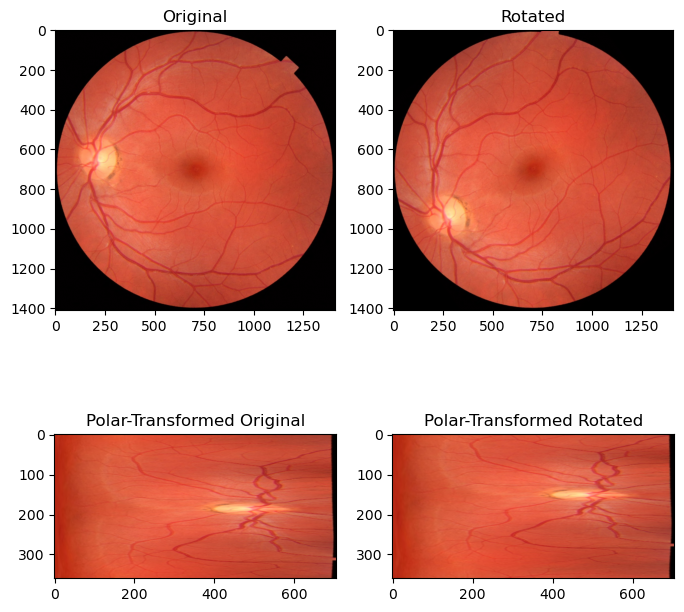

Expected value for counterclockwise rotation in degrees: 35
Recovered value for counterclockwise rotation: 35.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

radius = 705
angle = 35
image = data.retina()
image = img_as_float(image)
rotated = rotate(image, angle)
image_polar = warp_polar(image, radius=radius, channel_axis=-1)
rotated_polar = warp_polar(rotated, radius=radius, channel_axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated")
ax[1].imshow(rotated)
ax[2].set_title("Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Polar-Transformed Rotated")
ax[3].imshow(rotated_polar)
plt.show()

shifts, error, phasediff = phase_cross_correlation(
    image_polar, rotated_polar, normalization='phase'
)
print(f'Expected value for counterclockwise rotation in degrees: ' f'{angle}')
print(f'Recovered value for counterclockwise rotation: ' f'{shifts[0]}')

## Recover rotation and scaling differences with log-polar transform

In this second example, the images differ by both rotation and scaling (note
the axis tick values). By remapping these images into log-polar space,
we can recover rotation as before, and now also scaling, by phase
correlation.



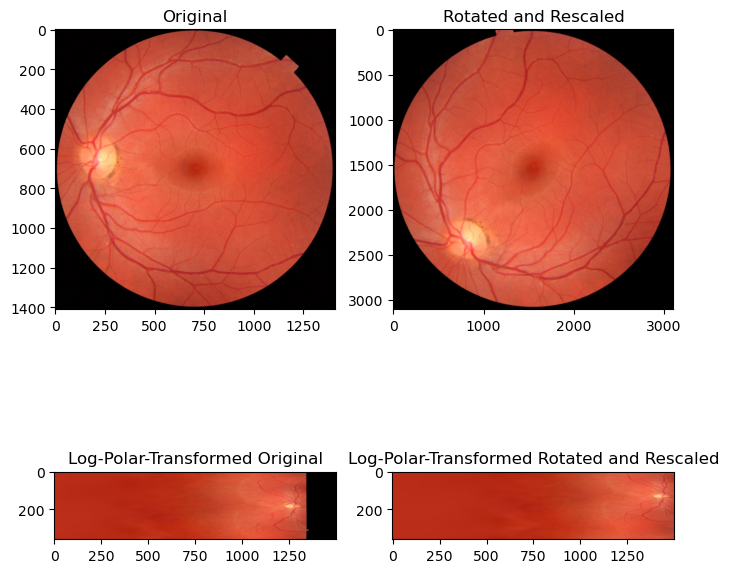

In [9]:
# radius must be large enough to capture useful info in larger image
radius = 1500
angle = 53.7
scale = 2.2
image = data.retina()
image = img_as_float(image)
rotated = rotate(image, angle)
rescaled = rescale(rotated, scale, channel_axis=-1)
image_polar = warp_polar(image, radius=radius, scaling='log', channel_axis=-1)
rescaled_polar = warp_polar(rescaled, radius=radius, scaling='log', channel_axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated and Rescaled")
ax[1].imshow(rescaled)
ax[2].set_title("Log-Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Log-Polar-Transformed Rotated and Rescaled")
ax[3].imshow(rescaled_polar)
plt.show()

# setting `upsample_factor` can increase precision
shifts, error, phasediff = phase_cross_correlation(
    image_polar, rescaled_polar, upsample_factor=20, normalization='phase'
)
shiftr, shiftc = shifts[:2]

# Calculate scale factor from translation
klog = radius / np.log(radius)
shift_scale = 1 / (np.exp(shiftc / klog))

In [10]:
print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {shiftr}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

Expected value for cc rotation in degrees: 53.7
Recovered value for cc rotation: 53.85

Expected value for scaling difference: 2.2
Recovered value for scaling difference: 2.199797163552113


## Register rotation and scaling on a translated image - Part 1

The above examples only work when the images to be registered share a
center. However, it is more often the case that there is also a translation
component to the difference between two images to be registered. One
approach to register rotation, scaling and translation is to first correct
for rotation and scaling, then solve for translation. It is possible to
resolve rotation and scaling differences for translated images by working on
the magnitude spectra of the Fourier-transformed images.

In this next example, we first show how the above approaches fail when two
images differ by rotation, scaling, and translation.



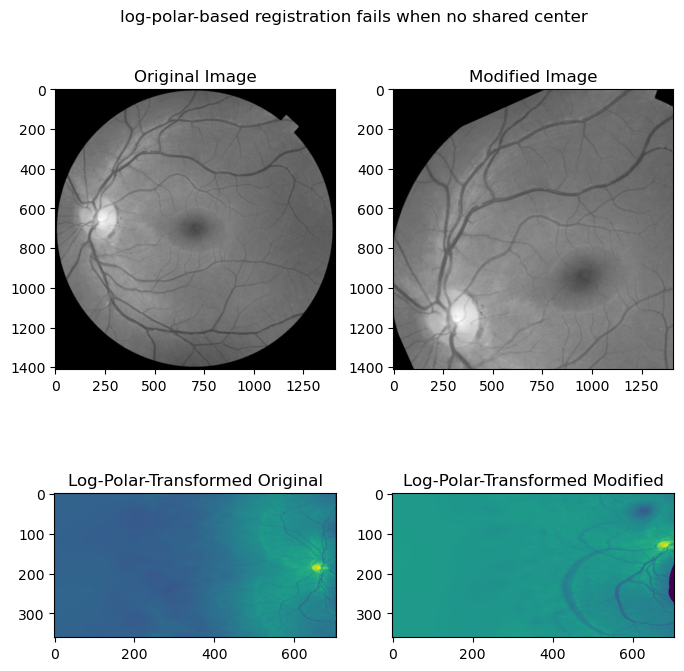

In [11]:
from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians
from scipy.fft import fft2, fftshift

angle = 24
scale = 1.4
shiftr = 30
shiftc = 15

image = rgb2gray(data.retina())
translated = image[shiftr:, shiftc:]
rotated = rotate(translated, angle)
rescaled = rescale(rotated, scale)
sizer, sizec = image.shape
rts_image = rescaled[:sizer, :sizec]

# When center is not shared, log-polar transform is not helpful!
radius = 705
warped_image = warp_polar(image, radius=radius, scaling="log")
warped_rts = warp_polar(rts_image, radius=radius, scaling="log")
shifts, error, phasediff = phase_cross_correlation(
    warped_image, warped_rts, upsample_factor=20, normalization='phase'
)
shiftr, shiftc = shifts[:2]
klog = radius / np.log(radius)
shift_scale = 1 / (np.exp(shiftc / klog))

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original Image")
ax[0].imshow(image, cmap='gray')
ax[1].set_title("Modified Image")
ax[1].imshow(rts_image, cmap='gray')
ax[2].set_title("Log-Polar-Transformed Original")
ax[2].imshow(warped_image)
ax[3].set_title("Log-Polar-Transformed Modified")
ax[3].imshow(warped_rts)
fig.suptitle('log-polar-based registration fails when no shared center')
plt.show()

In [12]:
print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {shiftr}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

Expected value for cc rotation in degrees: 24
Recovered value for cc rotation: 9.05

Expected value for scaling difference: 1.4
Recovered value for scaling difference: 1.0476106934350098


## Register rotation and scaling on a translated image - Part 2

We next show how rotation and scaling differences, but not translation
differences, are apparent in the frequency magnitude spectra of the images.
These differences can be recovered by treating the magnitude spectra as
images themselves, and applying the same log-polar + phase correlation
approach taken above.



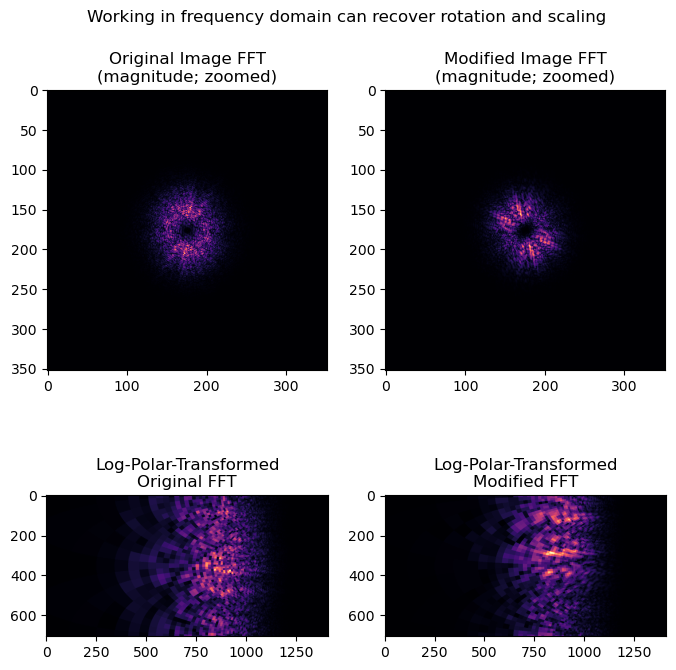

In [14]:
# First, band-pass filter both images
image = difference_of_gaussians(image, 5, 20)
rts_image = difference_of_gaussians(rts_image, 5, 20)

# window images
wimage = image * window('hann', image.shape)
rts_wimage = rts_image * window('hann', image.shape)

# work with shifted FFT magnitudes
image_fs = np.abs(fftshift(fft2(wimage)))
rts_fs = np.abs(fftshift(fft2(rts_wimage)))

# Create log-polar transformed FFT mag images and register
shape = image_fs.shape
radius = shape[0] // 8  # only take lower frequencies
warped_image_fs = warp_polar(
    image_fs, radius=radius, output_shape=shape, scaling='log', order=0
)
warped_rts_fs = warp_polar(
    rts_fs, radius=radius, output_shape=shape, scaling='log', order=0
)

warped_image_fs = warped_image_fs[: shape[0] // 2, :]  # only use half of FFT
warped_rts_fs = warped_rts_fs[: shape[0] // 2, :]
shifts, error, phasediff = phase_cross_correlation(
    warped_image_fs, warped_rts_fs, upsample_factor=10, normalization='phase'
)

# Use translation parameters to calculate rotation and scaling parameters
shiftr, shiftc = shifts[:2]
recovered_angle = (360 / shape[0]) * shiftr
klog = shape[1] / np.log(radius)
shift_scale = np.exp(shiftc / klog)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original Image FFT\n(magnitude; zoomed)")
center = np.array(shape) // 2
ax[0].imshow(
    image_fs[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ],
    cmap='magma',
)
ax[1].set_title("Modified Image FFT\n(magnitude; zoomed)")
ax[1].imshow(
    rts_fs[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ],
    cmap='magma',
)
ax[2].set_title("Log-Polar-Transformed\nOriginal FFT")
ax[2].imshow(warped_image_fs, cmap='magma')
ax[3].set_title("Log-Polar-Transformed\nModified FFT")
ax[3].imshow(warped_rts_fs, cmap='magma')
fig.suptitle('Working in frequency domain can recover rotation and scaling')
plt.show()

In [15]:

print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {recovered_angle}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

Expected value for cc rotation in degrees: 24
Recovered value for cc rotation: 0.7654145995747696

Expected value for scaling difference: 1.4
Recovered value for scaling difference: 1.1918721300171646


## Some notes on this approach

It should be noted that this approach relies on a couple of parameters
that have to be chosen ahead of time, and for which there are no clearly
optimal choices:

1. The images should have some degree of bandpass filtering
applied, particularly to remove high frequencies, and different choices here
may impact outcome. The bandpass filter also complicates matters because,
since the images to be registered will differ in scale and these scale
differences are unknown, any bandpass filter will necessarily attenuate
different features between the images. For example, the log-polar transformed
magnitude spectra don't really look "alike" in the last example here. Yet if
you look closely, there are some common patterns in those spectra, and they
do end up aligning well by phase correlation as demonstrated.

2. Images must be windowed using windows with circular symmetry, to remove
the spectral leakage coming from image borders. There is no clearly optimal
choice of window.

Finally, we note that large changes in scale will dramatically alter the
magnitude spectra, especially since a big change in scale will usually be
accompanied by some cropping and loss of information content. The literature
advises staying within 1.8-2x scale change [1]_ [2]_. This is fine for most
biological imaging applications.

### References

.. [1] B.S. Reddy and B.N. Chatterji. An FFT-based technique for translation,
       rotation and scale- invariant image registration. IEEE Trans. Image
       Processing, 5(8):1266–1271, 1996. :DOI:`10.1109/83.506761`

.. [2] Tzimiropoulos, Georgios, and Tania Stathaki. "Robust FFT-based
       scale-invariant image registration." In 4th SEAS DTC Technical
       Conference. 2009. :DOI:`10.1109/TPAMI.2010.107`

